In [1]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time

import random
import os

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, precision_score
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score

## 1. Extraction of training and test samples

For the comparaison then, we take the same split as in R. Let's import the test and train samples

In [2]:
train_set = pd.read_csv("data/train_set.txt",sep = ' ')
test_set = pd.read_csv("data/test_set.txt",sep = ' ')

In [3]:
X_train = pd.DataFrame(train_set)
del X_train['rain']
del X_train['rain_class']
del X_train['rain_log']

X_test = pd.DataFrame(test_set)
del X_test['rain']
del X_test['rain_class']
del X_test['rain_log']

In [4]:
Yr_train = train_set['rain']
Yr_test = test_set['rain']

In [5]:
Yr_log_train = train_set['rain_log']
Yr_log_test = test_set['rain_log']

In [6]:
Yb_train = train_set['rain_class']
Yb_test = test_set['rain_class']

Function transforms `rain` to `rain_class`

In [7]:
def to_class(rain, eps = 1e-2 ):
    myrain = (rain <= eps)*0 + (rain > eps)*(rain <= 2 )*1 + (rain > 2)*2
    myrain2 = myrain.astype('<U9')

    myrain2[myrain == 0] = 'no_rain'
    myrain2[myrain == 1] = 'low_rain'
    myrain2[myrain == 2] = 'high_rain'
    return myrain2

## 2.Linear regression without penalisation and without variable selection

### 2.1. With `rain`

In [8]:
from sklearn.linear_model import LinearRegression
regLin = LinearRegression().fit(X_train, Yr_train)
prev = regLin.predict(X_test)
print("Score=",regLin.score(X_test,Yr_test))

Score= 0.17941034878048068


In [9]:
# Mean Square Error
from sklearn.metrics import mean_squared_error
print("MSE=",mean_squared_error(prev,Yr_test))

MSE= 21.31252514066041


In [10]:
from sklearn.metrics import mean_absolute_percentage_error
print("MAPE =", mean_absolute_percentage_error(prev, Yr_test))

MAPE = 1.2192400252674


We can evaluate the accuracy by comparing the results into class with `rain_class`

In [11]:
from sklearn.metrics import accuracy_score
prev_class = to_class(prev)
print("Accuracy score =", accuracy_score(Yb_test.to_list(), prev_class))

Accuracy score = 0.4420289855072464


### 2.2. With `rain_log`

In [12]:
from sklearn.linear_model import LinearRegression
regLinLog = LinearRegression().fit(X_train, Yr_log_train)
prevLog = regLinLog.predict(X_test)
prev = np.exp(prevLog) - 1
print("Score=",regLinLog.score(X_test, Yr_log_test))prev = model_lasso.predict(X_test)
print("MSE=",mean_squared_error(prev,Yr_test))
print("R2=",r2_score(Yr_test,prev))
print("MAPE =",mean_absolute_percentage_error(Yr_test,prev))

prev_class = to_class(prev)
print("Accuracy score =", accuracy_score(Yb_test.to_list(), prev_class))

print("MSE=",mean_squared_error(prev,Yr_test))
print("MAPE=",mean_absolute_percentage_error(Yr_test, prev))

prev_class = to_class(prev)
print("Accuracy score =", accuracy_score(Yb_test.to_list(), prev_class))

Score= 0.24564049093258022
MSE= 18.363136477556324
MAPE= 1494003623307454.5
Accuracy score = 0.5072463768115942


By using `rain_log`, the value of MSE is reduced

## 3. Penalized regression 

### 3.1. Penalisation Lasso

#### 3.1.1. With `rain`

We implement the Lasso regression with the default values

In [13]:
from sklearn import linear_model
regLasso = linear_model.Lasso()
regLasso.fit(X_train,Yr_train)
prev=regLasso.predict(X_test)
print("MSE=",mean_squared_error(Yr_test,prev))
print("R2=",r2_score(Yr_test,prev))

MSE= 22.873572096345697
R2= 0.11930583425445629


The penalisation parameter is optimized by the cross validation

In [14]:
from sklearn.model_selection import GridSearchCV
param=[{"alpha":np.linspace(0,2,200)}]
regLasso = GridSearchCV(linear_model.Lasso(), param,cv=5,n_jobs=-1)
regLassOpt=regLasso.fit(X_train, Yr_train)
# Optimal parameter
regLassOpt.best_params_["alpha"]
print("Best R2 = %f, Best parameter = %s" % (regLassOpt.best_score_,regLassOpt.best_params_))

Best R2 = 0.200521, Best parameter = {'alpha': 0.1306532663316583}


Let's do some previsions with the optimized value of `lambda`

In [15]:
prev=regLassOpt.predict(X_test)
print("MSE=",mean_squared_error(prev,Yr_test))
print("R2=",r2_score(Yr_test,prev))
print("MAPE =",mean_absolute_percentage_error(Yr_test,prev))

prev_class = to_class(prev)
print("Accuracy score =", accuracy_score(Yb_test.to_list(), prev_class))

MSE= 20.127669408762078
R2= 0.22503048742510168
MAPE = 2685508596512427.5
Accuracy score = 0.4492753623188406


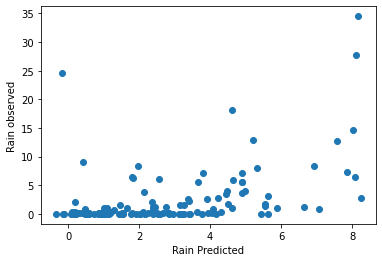

In [16]:
plt.plot(prev,Yr_test,"o")
plt.xlabel(u"Rain Predicted")
plt.ylabel("Rain observed")
plt.show()

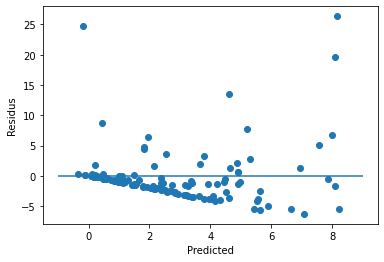

In [17]:
plt.plot(prev,Yr_test-prev,"o")
plt.xlabel(u"Predicted")
plt.ylabel(u"Residus")
plt.hlines(0,-1,9)
plt.show()

In [18]:
# Coefficients
regLasso=linear_model.Lasso(alpha=regLassOpt.best_params_['alpha'])
model_lasso=regLasso.fit(X_train,Yr_train)
model_lasso.coef_

array([ 0.        , -0.37687198, -0.        ,  0.        , -0.        ,
        0.38776323,  0.        ,  0.        ,  0.54709915,  0.78792087,
       -0.        , -0.22947443, -0.        , -0.        , -0.90195728,
        0.        ,  0.        , -0.        , -0.        ,  0.        ,
       -0.        ,  0.        , -0.        , -0.        ,  0.        ,
        0.        ])

In [19]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)
print("Lasso retain " + str(sum(coef != 0)) + 
      " variables and delete " +  str(sum(coef == 0)))

Lasso retain 6 variables and delete 20


In [20]:
prev = model_lasso.predict(X_test)
print("MSE=",mean_squared_error(prev,Yr_test))
print("R2=",r2_score(Yr_test,prev))
print("MAPE =",mean_absolute_percentage_error(Yr_test,prev))

prev_class = to_class(prev)
print("Accuracy score =", accuracy_score(Yb_test.to_list(), prev_class))

MSE= 20.127669408762078
R2= 0.22503048742510168
MAPE = 2685508596512427.5
Accuracy score = 0.4492753623188406


Text(0.5, 1.0, 'Lasso model coefficients')

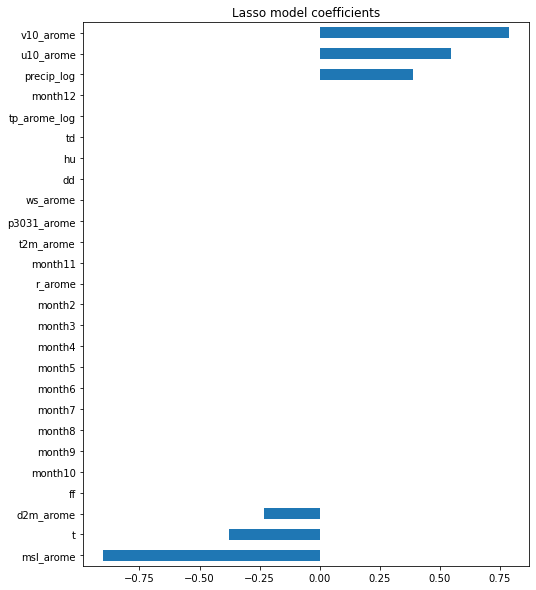

In [21]:
imp_coef = coef.sort_values()
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title(u"Lasso model coefficients")

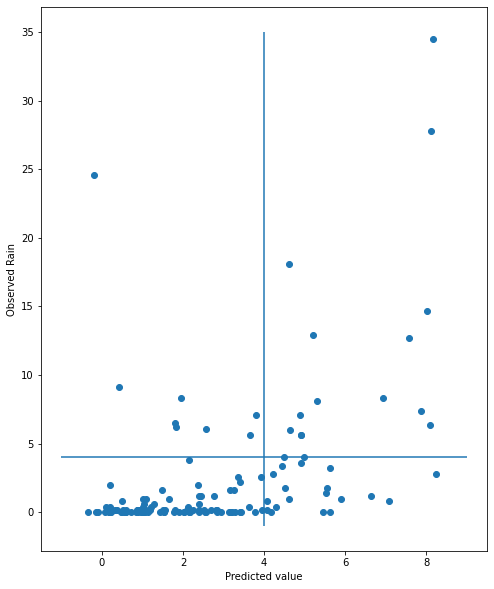

In [22]:
plt.plot(prev,Yr_test,"o")
plt.xlabel(u"Predicted value")
plt.ylabel(u"Observed Rain")
plt.hlines(4,-1,9)
plt.vlines(4,-1,35)
plt.show()

Confusion matrix

In [23]:
table=pd.crosstab(prev>4,Yr_test>4)
print(table)

rain   False  True
row_0             
False     96     8
True      20    14


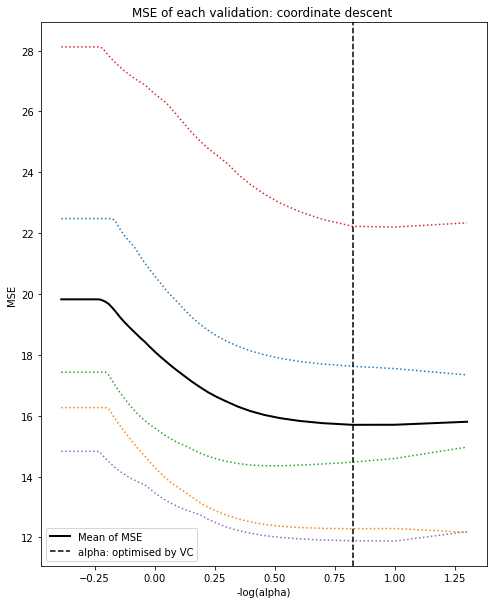

In [24]:
from sklearn.linear_model import LassoCV
model = LassoCV(cv=5, alphas=np.array(range(1,50,1))/20.,n_jobs=-1,random_state=13).fit(X_train,Yr_train)
m_log_alphas = -np.log10(model.alphas_)

plt.figure()
# ymin, ymax = 2300, 3800
plt.plot(m_log_alphas, model.mse_path_, ':')
plt.plot(m_log_alphas, model.mse_path_.mean(axis=-1), 'k',
         label='Mean of MSE', linewidth=2)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',
            label='alpha: optimised by VC')

plt.legend()

plt.xlabel('-log(alpha)')
plt.ylabel('MSE')
plt.title('MSE of each validation: coordinate descent ')
plt.show()

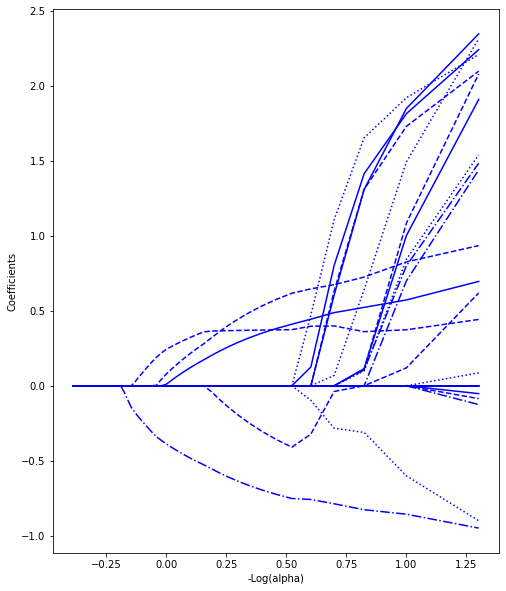

In [25]:
from itertools import cycle

from sklearn.linear_model import lasso_path
alphas_lasso, coefs_lasso, _ = lasso_path(X_train,Yr_train, alphas=np.array(range(1,50,1))/20.,)


plt.figure()
ax = plt.gca()

styles = cycle(['-', '--', '-.', ':'])

neg_log_alphas_lasso = -np.log10(alphas_lasso)
for coef_l, s in zip(coefs_lasso, styles):
    l1 = plt.plot(neg_log_alphas_lasso, coef_l, linestyle=s,c='b')
plt.xlabel('-Log(alpha)')
plt.ylabel('Coefficients')
plt.show()

#### 3.1.2. With `rain_log`

In [45]:
from sklearn.model_selection import GridSearchCV
param=[{"alpha":np.linspace(0,2,200)}]
regLasso = GridSearchCV(linear_model.Lasso(), param,cv=5,n_jobs=-1)
regLassOpt=regLasso.fit(X_train, Yr_log_train)
# optimal parameter 
regLassOpt.best_params_["alpha"]
print("Best R2 = %f, Best parameter = %s" % (regLassOpt.best_score_,regLassOpt.best_params_))

Best R2 = 0.295246, Best parameter = {'alpha': 0.03015075376884422}


In [46]:
prevLog=regLassOpt.predict(X_test)
prev = np.exp(prevLog) -1
print("MSE=",mean_squared_error(prev,Yr_test))
print("R2=",r2_score(Yr_test,prev))

prev_class = to_class(prev)
print("Accuracy score =", accuracy_score(Yb_test.to_list(), prev_class))

MSE= 19.96473201713183
R2= 0.23130401608892948
Accuracy score = 0.5


In [47]:
# Coefficients
regLasso=linear_model.Lasso(alpha=regLassOpt.best_params_['alpha'])
model_lasso=regLasso.fit(X_train,Yr_train)
model_lasso.coef_

array([-0.        , -0.20375486, -0.        ,  0.08559954, -0.16989959,
        0.61232737, -0.16450113,  0.        ,  0.85758931,  0.83716378,
       -0.        , -0.5743623 , -0.        , -0.3750943 , -1.10017857,
        0.        ,  0.        , -0.830107  , -0.24909363,  0.        ,
       -0.        ,  0.        , -0.28084807, -0.        ,  0.10972767,
        0.        ])

In [48]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)
print("Lasso retain " + str(sum(coef != 0)) + 
      " variables and delete " +  str(sum(coef == 0)))

Lasso retain 14 variables and delete 12


### 3.2. Penalisation Ridge

We implement the Ridge regression with the default values

In [28]:
from sklearn.linear_model import Ridge
regRidge = Ridge()
regRidge.fit(X_train,Yr_train)
prev = regRidge.predict(X_test)
print("MSE=" , mean_squared_error(Yr_test, prev))
print("R2=",r2_score(Yr_test,prev))

MSE= 21.088212065303658
R2= 0.18804700666386798


The penalisation parameter is optimized by the cross validation

In [49]:
from sklearn.model_selection import GridSearchCV
param=[{"alpha":np.linspace(0,100,200)}]
regRidge = GridSearchCV(Ridge(), param,cv=5,n_jobs=-1)
regRidOpt=regRidge.fit(X_train, Yr_train)
# optimal parameter
regRidOpt.best_params_["alpha"]
print("Best R2 = %f, Best parameter = %s" % (regRidOpt.best_score_,regRidOpt.best_params_))

Best R2 = 0.197437, Best parameter = {'alpha': 72.8643216080402}


Let's do some previsions with the optimized value of `lambda`

In [50]:
prev=regRidOpt.predict(X_test)
print("MSE=",mean_squared_error(prev,Yr_test))
print("R2=",r2_score(Yr_test,prev))

prev_class = to_class(prev)
print("Accuracy score =", accuracy_score(Yb_test.to_list(), prev_class))

MSE= 20.265155636838212
R2= 0.2197368971442747
Accuracy score = 0.4492753623188406


In [51]:
# Coefficients
regRidge=linear_model.Ridge(alpha=regRidOpt.best_params_['alpha'])
model_ridge=regRidge.fit(X_train,Yr_train)
model_ridge.coef_

array([-0.00609478, -0.21003643, -0.17658329,  0.22412766, -0.17680545,
        0.54767152, -0.08143842,  0.11997553,  0.67344925,  0.80855976,
       -0.07066287, -0.22937378, -0.185714  , -0.21812498, -0.93519253,
        0.21397538,  0.20276565, -0.42627867, -0.20873469,  0.08785838,
       -0.08625215,  0.02304334, -0.23611554, -0.11163307,  0.22927751,
        0.16829209])

In [32]:
coef = pd.Series(model_ridge.coef_, index = X_train.columns)
print("Ridge retains " + str(sum(coef != 0)) + 
      " variables and deletes " +  str(sum(coef == 0)))

Ridge retains 26 variables and deletes 0


Text(0.5, 1.0, 'Ridge model coefficients')

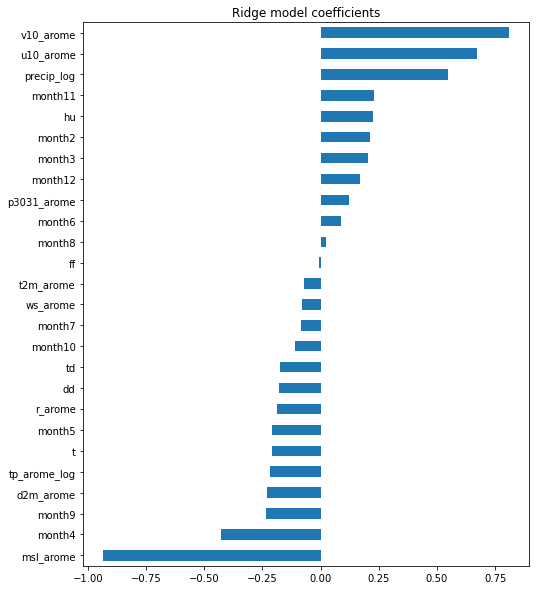

In [33]:
imp_coef = coef.sort_values()
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title(u"Ridge model coefficients")

In [34]:
prev = model_ridge.predict(X_test)
print("MSE=",mean_squared_error(prev,Yr_test))
print("R2=",r2_score(Yr_test,prev))
print("MAPE =",mean_absolute_percentage_error(Yr_test,prev))

prev_class = to_class(prev)
print("Accuracy score =", accuracy_score(Yb_test.to_list(), prev_class))

MSE= 20.265155636838212
R2= 0.2197368971442747
MAPE = 2750459238891696.0
Accuracy score = 0.4492753623188406


With `rain_log`

In [52]:
from sklearn.model_selection import GridSearchCV
param=[{"alpha":np.linspace(0,100,200)}]
regRidge = GridSearchCV(Ridge(), param,cv=5,n_jobs=-1)
regRidOpt=regRidge.fit(X_train, Yr_log_train)
# optimal parameter
regRidOpt.best_params_["alpha"]
print("Best R2 = %f, Best parameter = %s" % (regRidOpt.best_score_,regRidOpt.best_params_))

Best R2 = 0.295142, Best parameter = {'alpha': 44.723618090452256}


In [53]:
prevLog=regRidOpt.predict(X_test)
prev = np.exp(prevLog) -1
print("MSE=",mean_squared_error(prev,Yr_test))
print("R2=",r2_score(Yr_test,prev))

prev_class = to_class(prev)
print("Accuracy score =", accuracy_score(Yb_test.to_list(), prev_class))

MSE= 19.315240248667436
R2= 0.2563111994347145
Accuracy score = 0.5217391304347826


In [54]:
# Coefficients
regRidge=linear_model.Ridge(alpha=regRidOpt.best_params_['alpha'])
model_ridge=regRidge.fit(X_train,Yr_train)
model_ridge.coef_

array([ 0.02315269, -0.23376105, -0.2002722 ,  0.27413585, -0.25206068,
        0.58578056, -0.18194893,  0.15368724,  0.7514615 ,  0.84502073,
       -0.0181764 , -0.24505583, -0.24013888, -0.29433867, -1.00821262,
        0.27516914,  0.27063989, -0.5503875 , -0.29489482,  0.09214583,
       -0.12567836,  0.01896032, -0.32318273, -0.15177467,  0.30884364,
        0.23448788])

### 3.2. Penalisation Elastic

In [35]:
from sklearn.linear_model import ElasticNet
regElastic = ElasticNet()
regElastic.fit(X_train,Yr_train)
prev = regElastic.predict(X_test)
print("MSE=" , mean_squared_error(Yr_test, prev))
print("R2=",r2_score(Yr_test,prev))

MSE= 21.596675401226417
R2= 0.16846979801641615


In [57]:
from sklearn.model_selection import GridSearchCV
param=[{"alpha":np.linspace(0,2,50),"l1_ratio": np.linspace(0,1,25)}]
regElastic = GridSearchCV(ElasticNet(), param,cv=5,n_jobs=-1)
regElasOpt=regElastic.fit(X_train, Yr_train)
# optimal parameter
regElasOpt.best_params_["alpha"]
print("Best R2 = %f, Best parameter = %s" % (regElasOpt.best_score_,regElasOpt.best_params_))

Best R2 = 0.200532, Best parameter = {'alpha': 0.12244897959183673, 'l1_ratio': 0.9583333333333333}


Let's do some previsions with the optimized value of `lambda`

In [58]:
prev=regElasOpt.predict(X_test)
print("MSE=",mean_squared_error(prev,Yr_test))
print("R2=",r2_score(Yr_test,prev))
print("MAPE=",mean_absolute_percentage_error(Yr_test,prev))
prev_class = to_class(prev)
print("Accuracy score =", accuracy_score(Yb_test.to_list(), prev_class))

MSE= 20.12817853316162
R2= 0.22501088476372355
MAPE= 2686673707197718.5
Accuracy score = 0.4492753623188406


In [59]:
# Coefficients
regElastic=linear_model.ElasticNet(alpha=regElasOpt.best_params_['alpha'])
model_elastic=regElastic.fit(X_train,Yr_train)
model_elastic.coef_

array([-0.        , -0.28674809, -0.06736763,  0.03560469, -0.        ,
        0.46764149, -0.        , -0.        ,  0.59033191,  0.79704141,
       -0.        , -0.31923804, -0.        , -0.09143693, -0.90526434,
        0.        ,  0.        , -0.24297972, -0.        ,  0.        ,
       -0.        ,  0.        , -0.        , -0.        ,  0.        ,
        0.        ])

In [60]:
coef = pd.Series(model_elastic.coef_, index = X_train.columns)
print("Elastic retains " + str(sum(coef != 0)) + 
      " variables and deletes " +  str(sum(coef == 0)))

Elastic retains 10 variables and deletes 16


Text(0.5, 1.0, 'Elastic model coefficients')

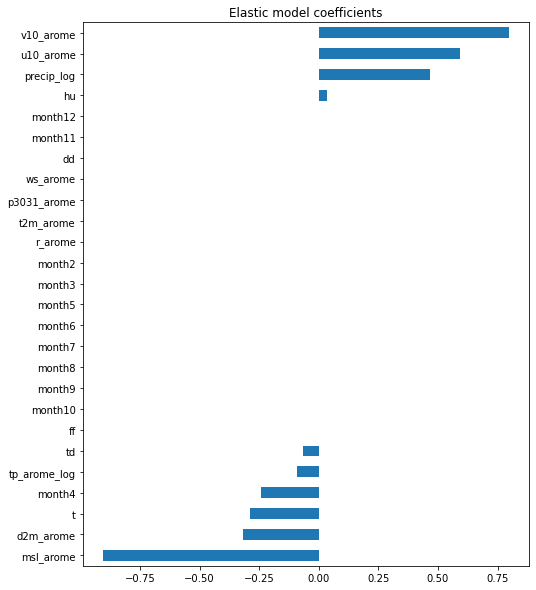

In [61]:
imp_coef = coef.sort_values()
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title(u"Elastic model coefficients")

With `rain_log`

In [63]:
from sklearn.model_selection import GridSearchCV
param=[{"alpha":np.linspace(0,2,50),"l1_ratio": np.linspace(0,1,25)}]
regElastic = GridSearchCV(ElasticNet(), param,cv=5,n_jobs=-1)
regElasOpt=regElastic.fit(X_train, Yr_log_train)
# optimal parameter
regElasOpt.best_params_["alpha"]
print("Best R2 = %f, Best parameter = %s" % (regElasOpt.best_score_,regElasOpt.best_params_))

Best R2 = 0.295159, Best parameter = {'alpha': 0.04081632653061224, 'l1_ratio': 0.6666666666666666}


## 4. Poisson Regression

In [42]:
from sklearn.linear_model import PoissonRegressor
regPoisson = PoissonRegressor()
regPoisson.fit(X_train,Yr_train)
prev = regPoisson.predict(X_test)
print("MSE=",mean_squared_error(Yr_test,prev))
print("R2=",r2_score(Yr_test,prev))

MSE= 18.2459145461268
R2= 0.2974831206170533


In [43]:
from sklearn.model_selection import GridSearchCV
param=[{"alpha":np.linspace(0,100,200)}]
regPoisson = GridSearchCV(PoissonRegressor(), param,cv=5,n_jobs=-1)
regPoiOpt=regPoisson.fit(X_train, Yr_train)
# optimal parameter
regPoiOpt.best_params_["alpha"]
print("Best R2 = %f, Best parameter = %s" % (regPoiOpt.best_score_,regPoiOpt.best_params_))

Best R2 = 0.261308, Best parameter = {'alpha': 0.5025125628140703}


In [44]:
prev=regPoiOpt.predict(X_test)
print("MSE=",mean_squared_error(prev,Yr_test))
print("R2=",r2_score(Yr_test,prev))
print("MAPE",mean_absolute_percentage_error(Yr_test,prev))
prev_class = to_class(prev)
print("Accuracy score =", accuracy_score(Yb_test.to_list(), prev_class))

MSE= 18.09334055209049
R2= 0.30335763054607934
MAPE 2568736417138601.5
Accuracy score = 0.4420289855072464
